In [128]:
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pybind11
import numpy.linalg as la
from scipy.stats import multivariate_normal

# 1. Vectorize using naive `numpy`

We stick to the example as in univariate normal simulation, where

$$X|\mu\sim N(\mu,1), \qquad \mu\sim N(0,1)$$

and we use different method to calcualte the gradient and seek possible ways of code optimization.

In [9]:
n = int(1e5)
nbatch= 500
data = np.random.normal(1, size = n)
idx = np.random.choice(len(data), nbatch)
batch = data[idx]

In [14]:
# 1. compare different ways of iterating over data.

# list comprehension
gradU_list = lambda mu, batch: mu + sum([mu-x for x in batch]) * len(data) / len(batch)

# for loop
gradUi = lambda mu, x: mu-x
def gradU_for(mu, batch):
    """
    Using forloop to calculate gradient.
    """
    
    gradU = 0
    for x in batch:
        gradU += gradUi(mu, x)
        
    gradU *= len(data) / len(batch)
    gradU += mu
    return gradU

# np.array vectorization
gradU_array = lambda mu, batch: mu + np.sum(mu-batch) * len(data) / len(batch)


In [15]:
%timeit gradU_for(1, batch)

225 µs ± 9.55 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [12]:
%timeit gradU_list(1, batch)

162 µs ± 2.5 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [16]:
%timeit gradU_array(1, batch)

9.36 µs ± 305 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [88]:
# time comparison
ls = (10 ** np.linspace(2, 5, 50)).astype(int)
T = np.zeros((len(ls), 3, 100))
f_list = [gradU_for, gradU_list, gradU_array]

for i, nbatch in enumerate(ls) :
    idx = np.random.choice(len(data), nbatch)
    batch = data[idx]
    for j, f in enumerate(f_list):
        for k in range(100):
            start = time.time()
            f(1, batch)
            elapsed = time.time() - start
            T[i, j, k] = elapsed
    print((i+1)/len(ls), end='\r')

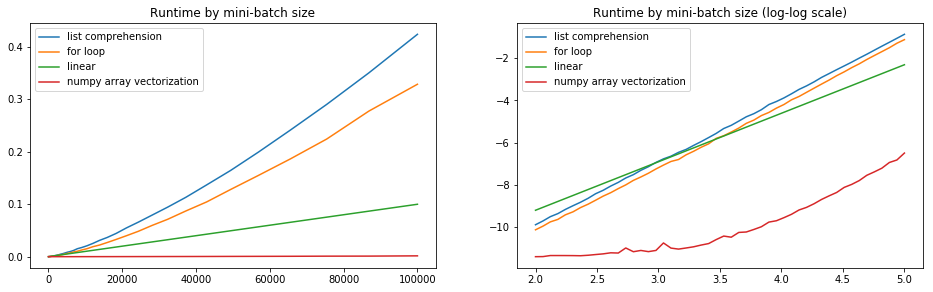

In [122]:
T_mean = T.mean(2)
T_sd = np.sqrt(((T-T.mean(2)[:,:,np.newaxis]) ** 2).mean(2))
T_log_mean = np.log(T).mean(2)

plt.figure(figsize=(16,4.5))
plt.subplot(121)
plt.plot(ls, T_mean[:,0], label = 'list comprehension')
plt.plot(ls, T_mean[:,1], label = 'for loop')
plt.plot(ls, ls*1e-6, label = 'linear')
plt.plot(ls, T_mean[:,2], label = 'numpy array vectorization')
plt.legend()
plt.title('Runtime by mini-batch size')
plt.subplot(122)
plt.plot(np.log10(ls), T_log_mean[:,0], label = 'list comprehension')
plt.plot(np.log10(ls), T_log_mean[:,1], label = 'for loop')
plt.plot(np.log10(ls), np.log(ls*1e-6), label = 'linear')
plt.plot(np.log10(ls), T_log_mean[:,2], label = 'numpy array vectorization')
plt.title('Runtime by mini-batch size (log-log scale)')
plt.legend();
# plt.savefig('runtime1.png');

# 2. Precompute invariant/common quantities

# 3. Use the easier version of sampler

As noted by the authors in the paper, there are two equivalent ways of updating our SGHMC samplar:

+ As in equation (13)

+ As in equation (15)

These two are obviously equivalent and we can use the second update rule and borrow experience from parameter settings of stochastic gradient descent with momentum. The $\beta$ term corresponds to the estimation of noise that comes from the gradient. One simple choice is to ignore the gradient noise by setting $\hat\beta$ = 0 and relying on small $\epsilon$. We can also set $\hat\beta =  \eta\hat V/2$, where $\hat V$ is estimated using empirical Fisher information as in (Ahn et al., 2012).

# 4. Using cython to detect the bottle neck

In [124]:
%load_ext cython

In [127]:
%%cython -a

import numpy as np
import scipy.linalg as la
nbatch = 500
np.random.seed(2019)
mean_or = np.array([1,-1])
sig_or = np.array([[1,0.75],[0.75,1]])
sig_or_i = la.inv(sig_or)
data = np.random.normal(1, size = 10000)
gradU = lambda mu, batch: mu - sig_or_i.dot((batch-mu).T).sum(1) / len(batch) * len(data)
Vhat = lambda mu, batch: np.cov(sig_or_i.dot((batch-mu).T))

def SGHMC(gradU, p, r, alpha, eta, beta = 0, eps = 0.01, L = 100):
    """
    Using leapfrog to discretalize
    
    Args:
        gradU: gradient of potential energy (posterior)
        p: position (parameters)
        r: momentum (auxiliary)
        eps: stepsize
        L: # of steps
        M_i: inversion of preconditioned mass matrix
    """

    v = eps * r
    for i in range(L):
        p += v
        idx = np.random.choice(len(data), nbatch)
        batch = data[idx]
        V = Vhat(p, batch)
        grad = gradU(p, batch)
        rnd = np.random.normal(0, 2*alpha*eta, 2)
        v = v - eta * grad - alpha * v + rnd
    return p, v

building '_cython_magic_2f39975556087cb91b180e9e247ffea6' extension
gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -I/opt/conda/lib/python3.6/site-packages/numpy/core/include -I/opt/conda/lib/python3.6/site-packages/numpy/core/include -I/opt/conda/lib/python3.6/site-packages/numpy/core/include -I/opt/conda/include/python3.6m -c /home/jovyan/.cache/ipython/cython/_cython_magic_2f39975556087cb91b180e9e247ffea6.c -o /home/jovyan/.cache/ipython/cython/home/jovyan/.cache/ipython/cython/_cython_magic_2f39975556087cb91b180e9e247ffea6.o
gcc -pthread -shared -L/opt/conda/lib -Wl,-rpath=/opt/conda/lib,--no-as-needed -L/opt/conda/lib -Wl,-rpath=/opt/conda/lib,--no-as-needed /home/jovyan/.cache/ipython/cython/home/jovyan/.cache/ipython/cython/_cython_magic_2f39975556087cb91b180e9e247ffea6.o -L/opt/conda/lib -lpython3.6m -o /home/jovyan/.cache/ipython/cython/_cython_magic_2f39975556087cb91b180e9e247ffea6.cpython-36m-x86_64-linux-gnu.so


As the results shows, the calculation of gradient and V costs huge amount of time and they are the very crucial part of our sampler. So we chose to code them in `C++` and use `pybind11` to wrap them.

In [129]:
%%file SGHMC_utils.cpp
<%
cfg["compiler_args"] = ["-std=c++11"]
cfg["include_dirs"] = ["../notebook/eigen"]
setup_pybind11(cfg)
%>

#include <pybind11/pybind11.h>
#include <pybind11/eigen.h>
#include <pybind11/numpy.h>

namespace py = pybind11;

double U(double mu, Eigen::VectorXd batch) {
    return mu*mu/2 + (mu-batch.array()).square().sum()/2;
}

double gradU(double mu, Eigen::VectorXd batch, int ndata) {
    return mu + (mu-batch.array()).sum() * ndata/ batch.size();
}

double Vhat(Eigen::VectorXd batch) {
    return (batch.array() - batch.mean()).square().sum()/(batch.size()-1);
}


PYBIND11_MODULE(SGHMC_utils, m) {
    m.doc() = "module to do calculate basic quantities for updating based on pybind11";
    m.def("U", &U, "Potential energy evaluated based one the whole dataset");
    m.def("gradU", &gradU, "estimated gradient of U based on minibatch");
    m.def("Vhat", &Vhat, "empirical Fishier Informatetion");
}

Overwriting SGHMC_utils.cpp


In [130]:
import cppimport
cppimport.force_rebuild()
SGHMC_utils=cppimport.imp("SGHMC_utils")

In [160]:
U_array = lambda mu, batch: mu**2/2 + np.sum((mu-batch)**2/2)
gradU_array = lambda mu, batch, ndata: mu + np.sum(mu-batch) * ndata / len(batch)
Vhat_array = lambda batch: np.cov(batch)

In [162]:
print(np.isclose(gradU_array(1, batch, len(data)), SGHMC_utils.gradU(1, batch, len(data))))
print(np.isclose(U_array(1, batch), SGHMC_utils.U(1, batch)))
print(np.isclose(Vhat_array(batch), SGHMC_utils.Vhat(batch)))

True
True
True


In [163]:
%timeit gradU_array(1, batch, len(data))

133 µs ± 2.44 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [135]:
%timeit SGHMC_utils.gradU(1, batch, len(data))

113 µs ± 1.21 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [152]:
%timeit Vhat_array(batch)

1.14 ms ± 184 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [153]:
%timeit SGHMC_utils.Vhat(batch)

146 µs ± 864 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [166]:
def SGHMC_update(Vhat, gradU, p, r, nbatch = 50, eps = 0.01, L = 100, M_i = 1):
    """
    Using leapfrog to discretalize
    
    Args:
        Vhat: empirical fisher info matrix
        gradU: gradient of potential energy (posterior)
        p: position (parameters)
        r: momentum (auxiliary)
        eps: stepsize
        L: # of steps
        M_i: inversion of preconditioned mass matrix
    """


    for i in range(L):
        p = p + eps*M_i * r
        idx = np.random.choice(len(data), nbatch)
        batch = data[idx]
        V = Vhat(batch)
        B = 1/2 * eps * V
        C = 3
        r = r - eps*gradU(p, batch, len(data)) - eps*C*M_i*r + np.random.normal(0, np.sqrt(2*(C-B)*eps))
    return p, r

In [158]:
p, r0 = 0, 0

In [164]:
%timeit SGHMC_update(Vhat, gradU_array, p, r0, eps = 0.01, L = 100, M_i = 1)

14.8 ms ± 209 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [165]:
%timeit SGHMC_update(SGHMC_utils.Vhat, SGHMC_utils.gradU, p, r0, eps = 0.01, L = 100, M_i = 1)

4.78 ms ± 101 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [176]:
data = np.random.normal(1, size = int(1e5))
ls = (10 ** np.linspace(2, 5, 10)).astype(int)
T2 = np.zeros((len(ls), 100, 2))

for i, nbatch in enumerate(ls):
    for j in range(100):
        t1 = time.time()
        SGHMC_update(Vhat, gradU_array, p, r0, nbatch, eps = 0.01, L = 100, M_i = 1)
        t2 = time.time()
        SGHMC_update(SGHMC_utils.Vhat, SGHMC_utils.gradU, p, r0, eps = 0.01, L = 100, M_i = 1)
        t3 = time.time()
        T2[i, j, 0] = t2 - t1
        T2[i, j, 1] = t3 - t2
    print((i+1)/len(ls), end='\r')

In [186]:
Tpy = T2.mean(1)[:,0]
Tc = T2.mean(1)[:,1]
print(Tpy)
print(Tc)

[0.01329327 0.01420393 0.01483635 0.01621503 0.01845416 0.02328839
 0.03403129 0.15678854 0.26192291 0.28850595]
[0.00363149 0.00356748 0.00365649 0.00362825 0.00354905 0.00358202
 0.00372468 0.00407288 0.00370974 0.0039533 ]


In [231]:
import pandas as pd
T2l = np.log10(T2)

In [232]:
df1 = pd.melt(pd.DataFrame(T2l[:,:,0].T, columns=ls), col_level=0)
df2 = pd.melt(pd.DataFrame(T2l[:,:,1].T, columns=ls), col_level=0)

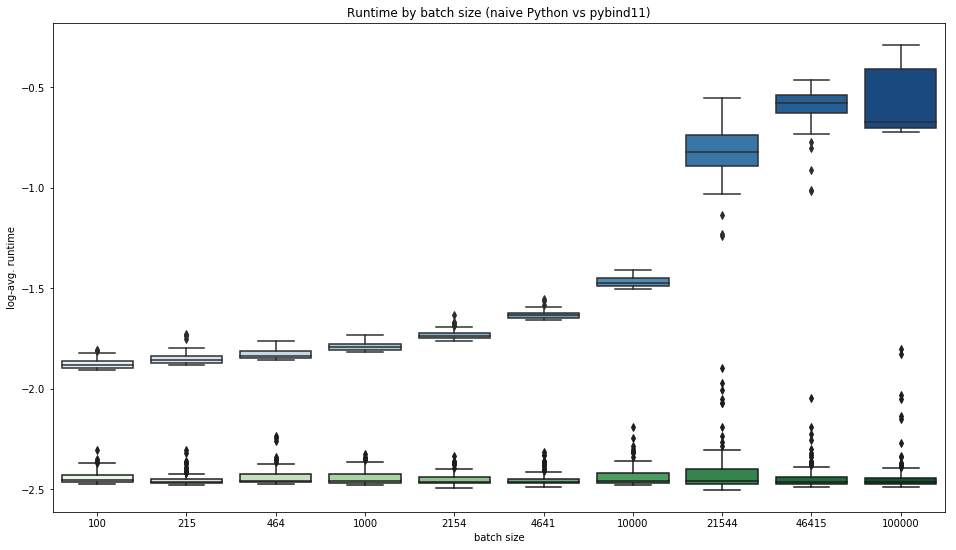

In [248]:
plt.figure(figsize=(16,9))
sns.boxplot(y="value", x= "variable", data = df1, palette = sns.color_palette("Blues", n_colors = 10))
sns.boxplot(y="value", x= "variable", data = df2, palette = sns.color_palette("Greens", n_colors = 10))
plt.xlabel('batch size')
plt.ylabel('log-avg. runtime')
plt.title("Runtime by batch size (naive Python vs pybind11)");
# plt.savefig("py_vs_cpp.png");